In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [2]:
path = '../../../../ruairidh/model_results/run_1/saves/csvs/'
csv_fns = [_ for _ in os.listdir(path) if '.csv' in _]
print(csv_fns[0])

vgg_15_BN_64_con_False_lr_0.01_seed_1_scores.csv


In [3]:
def parse_filenames(filenames):
    model_specs = []
    
    for filename in filenames:
        model_spec = {}
        model_spec['csv'] = filename

        model_spec['model_name'] = filename[:filename.find('con')-1]
        filename = filename[filename.find('con')+4:]
        if filename[:filename.find('_')]=='False':
            model_spec['human'] = True
        else:
            model_spec['human'] = False
        filename = filename[filename.find('lr_')+3:]
        model_spec['lr'] = float(filename[:filename.find('_')])
        filename = filename[filename.find('seed')+5:]
        model_spec['seed'] = int(filename[:filename.find('_')])
            
        model_specs.append(model_spec)
    
    return model_specs

print(parse_filenames(csv_fns)[0])

{'csv': 'vgg_15_BN_64_con_False_lr_0.01_seed_1_scores.csv', 'model_name': 'vgg_15_BN_64', 'human': True, 'lr': 0.01, 'seed': 1}


In [4]:
model_specs = parse_filenames(csv_fns)

In [5]:
# merge all data into one big pandas df
for i, model_spec in enumerate(model_specs):
    
    # read csv
    current_df = pd.read_csv(os.path.join(path, model_spec['csv']))
    if current_df.shape[0] < 101:
        size_warning = 'WARNING: '
        size_warning += model_spec['model_name']+' only has '+str(current_df.shape[0])+'/100 epochs'
        print(size_warning)
        
    # add meta to current csv
    for key in model_spec.keys():
        if key != 'csv': 
            current_df[key] = model_spec[key]
            
    if i == 0:
        df = current_df.copy()
    else:
        df = pd.concat([df, current_df])
        
df = df.reset_index()

In [6]:
print(df.keys())
df.head()

Index(['index', 'epoch', 'c10h_train_loss', 'c10h_train_acc', 'c10h_val_loss',
       'c10h_val_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
       'c10h_val_c10_loss', 'c10h_val_c10_acc', 'v4_loss', 'v4_acc', 'v6_loss',
       'v6_acc', 'c10_50k_loss', 'c10_50k_acc', 'model_name', 'human', 'lr',
       'seed'],
      dtype='object')


,index,epoch,c10h_train_loss,c10h_train_acc,c10h_val_loss,c10h_val_acc,c10h_train_c10_loss,c10h_train_c10_acc,c10h_val_c10_loss,c10h_val_c10_acc,v4_loss,v4_acc,v6_loss,v6_acc,c10_50k_loss,c10_50k_acc,model_name,human,lr,seed
0,0,0,0.794967,0.919556,0.776351,0.945,0.369321,0.920111,0.297674,0.947,0.838030,0.834240,0.788210,0.8535,0.002137,0.99956,vgg_15_BN_64,True,0.01,1
1,1,1,0.463000,0.920000,0.478384,0.922,0.236204,0.920667,0.227456,0.924,0.615054,0.818902,0.562245,0.8395,0.039436,0.99158,vgg_15_BN_64,True,0.01,1
2,2,2,0.358241,0.933444,0.383376,0.932,0.198980,0.934556,0.206034,0.934,0.508731,0.831766,0.467999,0.8475,0.068284,0.99380,vgg_15_BN_64,True,0.01,1
3,3,3,0.331081,0.942444,0.367047,0.934,0.182635,0.943000,0.205339,0.936,0.510393,0.833251,0.455903,0.8460,0.070515,0.99418,vgg_15_BN_64,True,0.01,1
4,4,4,0.319080,0.945222,0.362204,0.934,0.171912,0.946000,0.203533,0.935,0.505392,0.837209,0.454368,0.8430,0.068090,0.99454,vgg_15_BN_64,True,0.01,1


In [7]:
benchmark_data = []

for mn in df.model_name.unique()[::-1]:
    
    for ht in [True, False]:

        if ht:
            idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_loss.idxmin()
        else:
            idxmin = df[(df.model_name==mn) & (df.human==ht)].c10h_val_c10_loss.idxmin()
            print
            
        row = dict(df[(df.model_name==mn) & (df.human==ht)].loc[idxmin])
        del row['index']
        benchmark_data.append(row)
        
        hp_selector = (df.model_name==mn) & \
                      (df.human==ht) & \
                      (df.lr==row['lr']) & \
                      (df.seed==row['seed']) & \
                      (df.epoch==0)
        ep0_row = dict(df[hp_selector].reset_index().loc[0])
        del ep0_row['index'], ep0_row['level_0']
        benchmark_data.append(ep0_row)

b_df = pd.DataFrame(benchmark_data)
b_df

,c10_50k_acc,c10_50k_loss,c10h_train_acc,c10h_train_c10_acc,c10h_train_c10_loss,c10h_train_loss,c10h_val_acc,c10h_val_c10_acc,c10h_val_c10_loss,c10h_val_loss,epoch,human,lr,model_name,seed,v4_acc,v4_loss,v6_acc,v6_loss
0,0.98352,0.093114,0.987444,0.983444,0.066106,0.195256,0.949,0.949,0.166645,0.315630,47,True,0.010,densenet_BC_100_12,0,0.867392,0.401294,0.8775,0.377961
1,0.99998,0.000641,0.941111,0.943222,0.212312,0.627269,0.961,0.962,0.147656,0.613540,0,True,0.010,densenet_BC_100_12,0,0.883226,0.505212,0.8890,0.541001
2,0.99974,0.002901,0.969000,0.973000,0.071200,0.491760,0.957,0.958,0.135619,0.565883,4,False,0.001,densenet_BC_100_12,0,0.881247,0.456320,0.8855,0.491156
3,0.99998,0.000641,0.941111,0.943222,0.212312,0.627269,0.961,0.962,0.147656,0.613540,0,False,0.001,densenet_BC_100_12,0,0.883226,0.505212,0.8890,0.541001
4,0.99548,0.057687,0.985222,0.982889,0.074920,0.216723,0.957,0.959,0.132949,0.280957,6,True,0.010,wrn_28_10_cutout16,0,0.882731,0.366981,0.8890,0.335018
5,0.99998,0.001012,0.951000,0.953111,0.164471,0.463454,0.960,0.963,0.139544,0.452306,0,True,0.010,wrn_28_10_cutout16,0,0.895101,0.380155,0.9025,0.377669
6,0.99990,0.003035,0.968000,0.972222,0.074275,0.365051,0.962,0.965,0.110163,0.419722,2,False,0.001,wrn_28_10_cutout16,1,0.889164,0.370680,0.9005,0.345901
7,0.99998,0.001012,0.949333,0.952000,0.173595,0.466305,0.964,0.966,0.124278,0.467991,0,False,0.001,wrn_28_10_cutout16,1,0.895101,0.380155,0.9025,0.377669
8,0.92996,0.226056,0.990111,0.985778,0.062004,0.193356,0.925,0.925,0.237135,0.362633,100,True,0.100,resnet_basic_110,1,0.821376,0.557528,0.8165,0.542124
9,0.99976,0.002832,0.920667,0.922222,0.312123,0.721923,0.939,0.938,0.292607,0.777623,0,True,0.100,resnet_basic_110,1,0.846116,0.660880,0.8545,0.737634


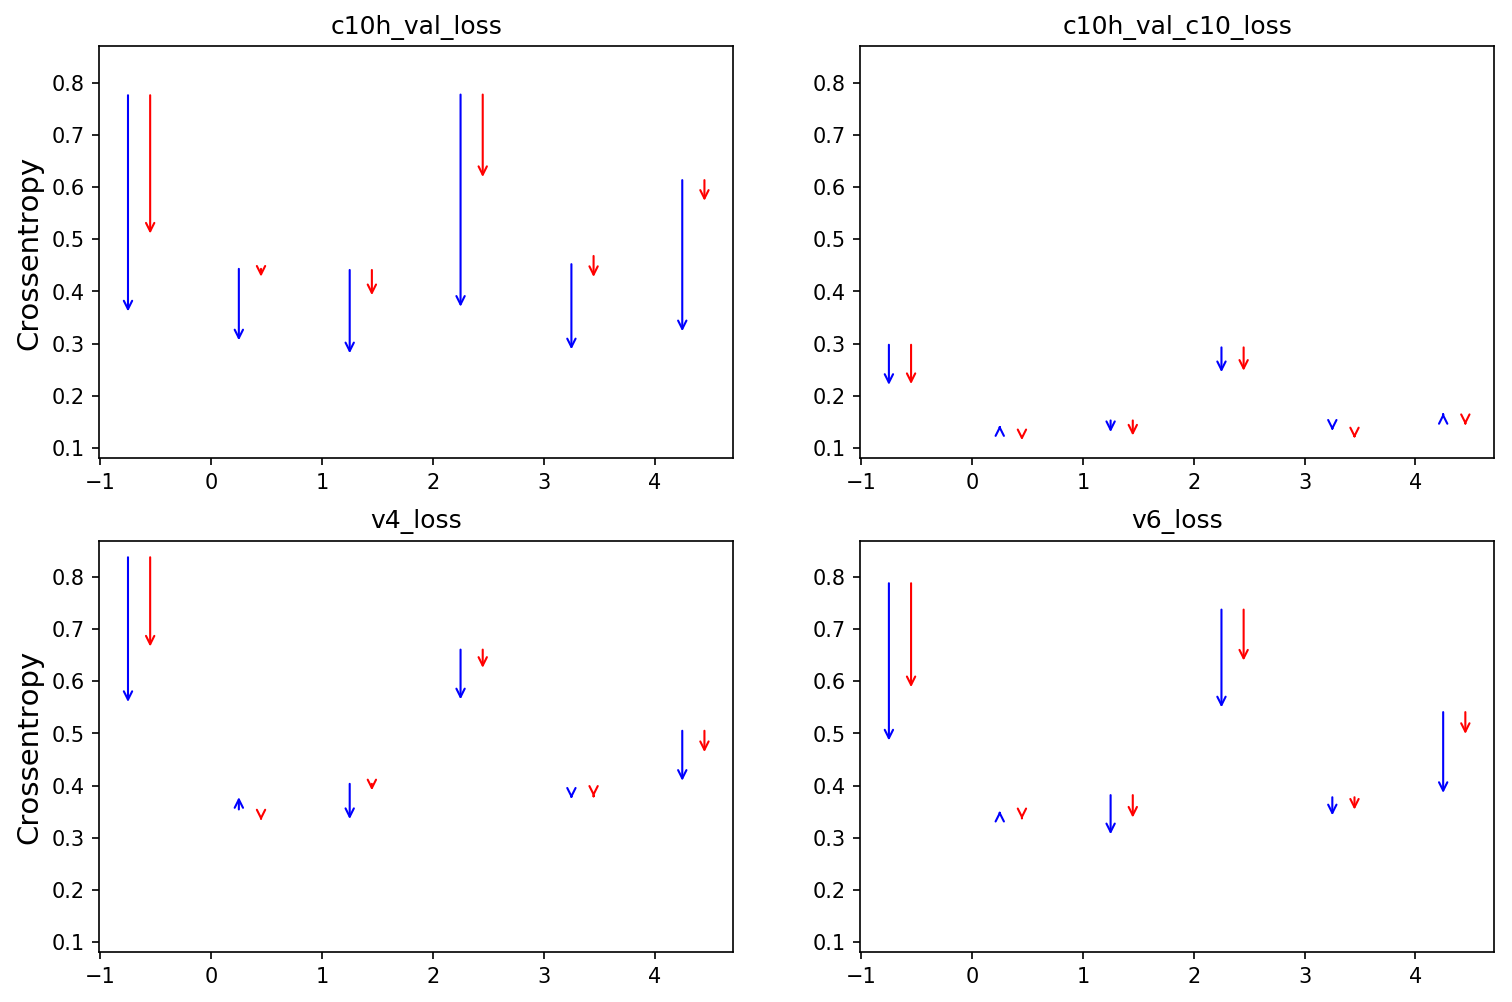

In [8]:
colors= ['blue','red']

plt.figure(figsize=(12,8), dpi=150)

for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
    plt.subplot(2, 2, plot_i+1)
    for m, mn in enumerate(b_df.model_name.unique()[::-1]):

        for h, human in enumerate([True, False]):
            start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
            end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]

            extra = 0.25
            if h==1: extra=0.45
            space = 1.0
            x = m*space-1+extra

#             plt.plot([x, x], [start, end], color=colors[h], linewidth=1, zorder=-999)
#             plt.scatter(x, end, marker='o', color='white', s=40, edgecolor=colors[h])
            plt.annotate('', xy=(x, end), xytext=(x, start+0.008), 
                         arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                         va='center')
            plt.scatter(x, start, marker='_', color=None, s=0, edgecolor=None)
            plt.ylim([0.08,0.87])
            plt.title(loss_key)

    if plot_i % 2 == 0: plt.ylabel('Crossentropy', fontsize=14)

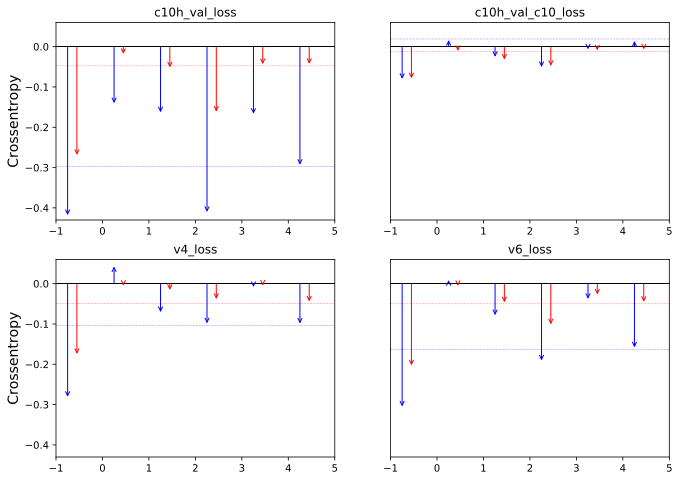

In [49]:
colors= ['blue','red']

plt.figure(figsize=(11,8), dpi=200)

for plot_i, loss_key in enumerate(['c10h_val_loss', 'c10h_val_c10_loss', 'v4_loss', 'v6_loss']):
    plt.subplot(2, 2, plot_i+1)
    for m, mn in enumerate(b_df.model_name.unique()[::-1]):
        human_mags = []
        nonhuman_mags = []

        for h, human in enumerate([True, False]):
            
            start = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch==0)][loss_key].values[0]
            end = b_df[(b_df.model_name==mn)&(b_df.human==human)&(b_df.epoch!=0)][loss_key].values[0]
            
            mag = end - start
            if human: 
                human_mags.append(mag)
            else:
                nonhuman_mags.append(mag)

            extra = 0.25
            if h==1: extra=0.45
            space = 1.0
            x = m*space-1+extra

#             plt.plot([x, x], [start, end], color=colors[h], linewidth=1, zorder=-999)
#             plt.scatter(x, end, marker='o', color='white', s=40, edgecolor=colors[h])
            if mag < 0: 
                plt.annotate('', xy=(x, mag), xytext=(x, 0.003), 
                             arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                             va='center')
            else:
                plt.annotate('', xy=(x, mag), xytext=(x, -0.003), 
                             arrowprops={'arrowstyle': '->', 'color':colors[h], 'lw':1.0}, 
                             va='center')
            plt.scatter(x, mag, marker='_', color=None, s=0, edgecolor=None)
        
            plt.plot([-1, 5], [0, 0], color='black', linewidth=0.6, zorder=-999)
            plt.ylim([-0.43, 0.06])
            plt.xlim([-1, 5])
            plt.title(loss_key)
    plt.plot([-1, 5], [np.mean(human_mags), np.mean(human_mags)], '--', color='blue',
             linewidth=0.6, zorder=-999, alpha=0.4)
    plt.plot([-1, 5], [np.mean(nonhuman_mags), np.mean(nonhuman_mags)], '--', color='red',
             linewidth=0.6, zorder=-999, alpha=0.4)
    if plot_i % 2 == 0: 
        plt.ylabel('Crossentropy', fontsize=14)
    else:
        plt.gca().axes.get_yaxis().set_visible(False)